# Compare DM / DM with Nystrom extension / roseland using medical signals

## Define functions

### import libraries

In [1]:
%pylab inline

from scipy.spatial.distance import cdist
from scipy.sparse.linalg import svds
from scipy.stats import norm
from math import ceil
from scipy import sparse

from scipy.io import loadmat, savemat
from mpl_toolkits.mplot3d import Axes3D

set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

Populating the interactive namespace from numpy and matplotlib


### plot results

In [2]:
def plotemb(EMB,title):
    n = EMB.shape[0]
    
    cmap   = cm.jet
    col    = cmap(linspace(0,1,n))
    colbar = plt.cm.ScalarMappable(cmap=cmap)
    
    fig = plt.figure()
    ax  = Axes3D(fig)

    ax.scatter(EMB[:,1],EMB[:,2],EMB[:,3],s=2,c=col)

    plt.gcf().set_size_inches(10,6)
    plt.title(title+' embedding')
    plt.colorbar(colbar)
    plt.show()

### DM / roseland / DM with Nystrom extension

In [3]:
def MKs(X,Y,sigma):
    
    dist = cdist(X,Y)
    K    = exp(-dist**2/sigma)
    K[K<5e-5] = 0
    
    return sparse.csr_matrix(K)

In [4]:
def MK(X,Y,sigma):
    
    dist = cdist(X,Y)
    
    return exp(-dist**2/sigma)

In [5]:
def DM(X,sigma,dim=6):
    n = X.shape[0]
    
    K = MKs(X,X,sigma)
    # Q = vstack((arange(n), sum(K,axis=1))).T
    D = sparse.dia_matrix((array(1/sqrt(sum(K,axis=1)))[:,0],0),shape=(n,n))
    A = D.dot(K).dot(D)
    
    U,S,V = svds(A,dim)
    
    S = S[::-1]
    U = U[:,::-1]
    
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = D.dot(U).dot(diag(S))
        
    return emb, S

In [6]:
def roseland(X,Y,sigma,dim=6):
    n = X.shape[0]
    m = Y.shape[0]

    K = MKs(X,Y,sigma)    
    tmp1 = K.sum(axis=0).reshape(m,1)
    tmp2 = K.dot(tmp1)

    D    = sparse.dia_matrix((array(1/sqrt(tmp2))[:,0],0),shape=(n,n))
    A    = D.dot(K)

    U,S,V = svds(A,dim)
    
    S = S[::-1]**2
    U = U[:,::-1]
    
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = D.dot(U).dot(diag(S))
        
    return emb, S

In [7]:
def nystrom(X,Y,sample,sigma,dim=6):
    n = X.shape[0]
    m = Y.shape[0]

    ind1 = sample
    ind2 = delete(arange(n),ind1)
    ind = hstack((ind1,ind2))

    K = MK(X,Y,sigma) 
    K = K[ind]
    D = sparse.dia_matrix((1/sqrt(sum(K,axis=1)),0),shape=(n,n))
    Dsm = diag(1/sqrt(sum(K,axis=0)))

    Q = D.dot(K).dot(Dsm)
    A = Q[:m]
    B = Q[m:]
    
    uu,ss,vv = svd(A,full_matrices=False)
    AA = uu.dot(diag(1/sqrt(ss))).dot(vv)
        
    SS = A + AA.dot(B.T).dot(B).dot(AA)
        
    U,S,VV = svds(SS,dim)
    
    S = S[::-1]
    U = U[:,::-1]*sqrt(n)
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
    
    V = Q.dot(AA).dot(U).dot(diag(1/sqrt(S)))

    emb = D.dot(V).dot(diag(S))

    emb2 = zeros((n,dim))
    emb2[ind1] = emb[:m]
    emb2[ind2] = emb[m:]
    
    return emb2

## Pleth signal

X: data set, size n

Y: landmark set uniformly chosen from X, size m 

XX: data set 2, size nn (for computing DM)

In [8]:
X = loadmat('/content/Pulses_Pleth.mat')['Pulses_Pleth']

In [9]:
n = X.shape[0]

m = round(n**0.45)
Yind = arange(n)[::int(ceil(n/m))][:m]
Y    = X[Yind]

nn = 1200
XX = X[::int(floor(n/nn))][:nn]

print('size of X, n = ',n)
print('size of Y, m = ',m)
print('size of XX, nn = ',nn)

size of X, n =  121814
size of Y, m =  194
size of XX, nn =  1200


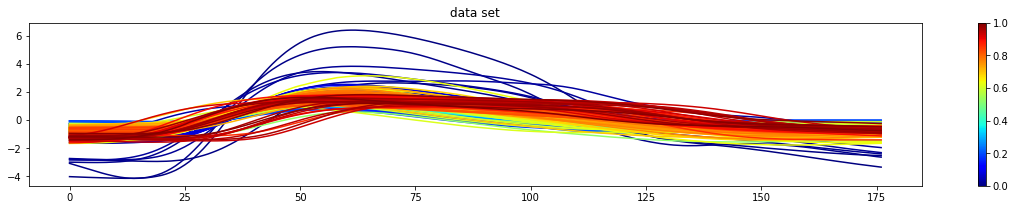

In [10]:
cmap   = cm.jet
col    = cmap(linspace(0,1,n))
colbar = plt.cm.ScalarMappable(cmap=cmap)

for i in Yind:
    plot(X[i],c=col[i])

plt.gcf().set_size_inches(20,3)
plt.colorbar(colbar)
plt.title('data set')
plt.show()

### DM of XX

In [11]:
%%time
sigma = 1e+4

EMBdm, EIGdm = DM(XX,sigma)

CPU times: user 708 ms, sys: 86.4 ms, total: 794 ms
Wall time: 1.06 s



eigenvalues:  [1.00000 0.00612 0.00236 0.00078 0.00031 0.00017]


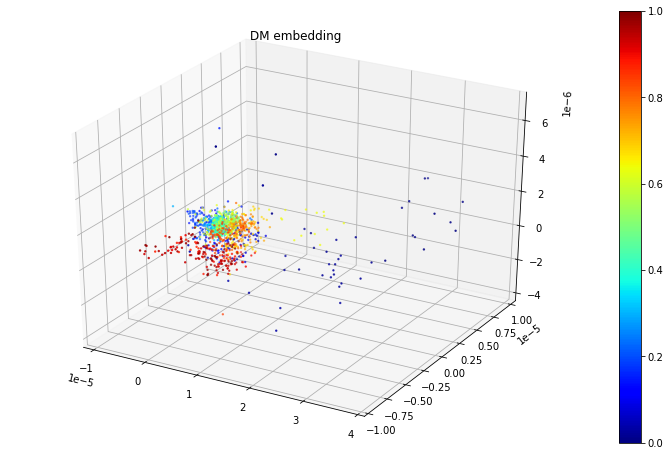

In [12]:
print('\neigenvalues: ',EIGdm)
plotemb(EMBdm,'DM')
savemat('EMBdm.mat',{'EMBdm': EMBdm})

### roseland of X

In [13]:
%%time
sigma = 1e+4

EMBr,EIGr = roseland(X,Y,sigma)

CPU times: user 6.64 s, sys: 237 ms, total: 6.88 s
Wall time: 8.75 s



eigenvalues:  [1.00000 0.00003 0.00001 0.00000 0.00000 0.00000]


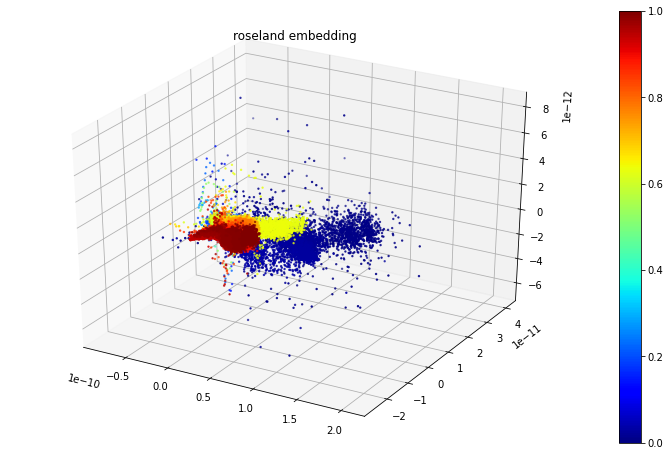

In [14]:
print('\neigenvalues: ',EIGr)
plotemb(EMBr,'roseland')
savemat('EMBr.mat',{'EMBr': EMBr})

### DM with Nystrom extension of X

In [15]:
%%time
sigma = 1e+4

EMBn = nystrom(X,Y,Yind,sigma)

CPU times: user 5.49 s, sys: 160 ms, total: 5.65 s
Wall time: 4.47 s


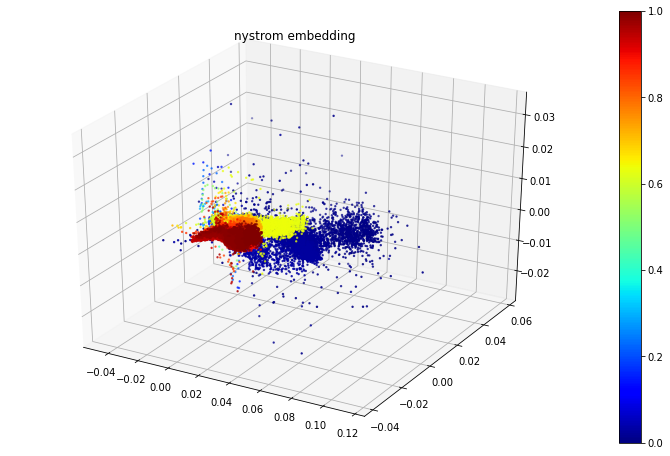

In [16]:
plotemb(EMBn,'nystrom')
savemat('EMBn.mat',{'EMBn': EMBn})

## ECG signal

X: data set, size n

Y: landmark set uniformly chosen from X, size m

XX: data set 2, size nn (for computing DM)

In [17]:
X = loadmat('/content/Pulses_GE_ECG.mat')['Pulses_GE_ECG']

In [18]:
n = X.shape[0]

m = round(n**0.45)
Yind = arange(n)[::int(ceil(n/m))][:m]
Y    = X[Yind]

nn = 1200
XX = X[::int(floor(n/nn))][:nn]

print('size of X, n = ',n)
print('size of Y, m = ',m)
print('size of XX, nn = ',nn)

size of X, n =  113460
size of Y, m =  188
size of XX, nn =  1200


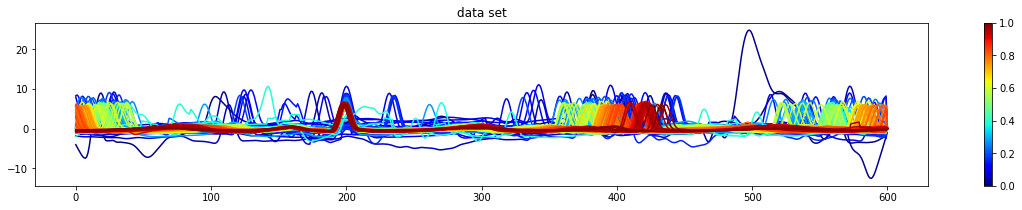

In [19]:
cmap   = cm.jet
col    = cmap(linspace(0,1,n))
colbar = plt.cm.ScalarMappable(cmap=cmap)

for i in Yind:
    plot(X[i],c=col[i])

plt.gcf().set_size_inches(20,3)
plt.colorbar(colbar)
plt.title('data set')
plt.show()

### DM of XX

In [20]:
%%time
sigma = 1e+4

EMBdm2, EIGdm2 = DM(XX,sigma)

CPU times: user 983 ms, sys: 98.2 ms, total: 1.08 s
Wall time: 985 ms



eigenvalues:  [1.00000 0.42659 0.03210 0.02188 0.01379 0.01117]


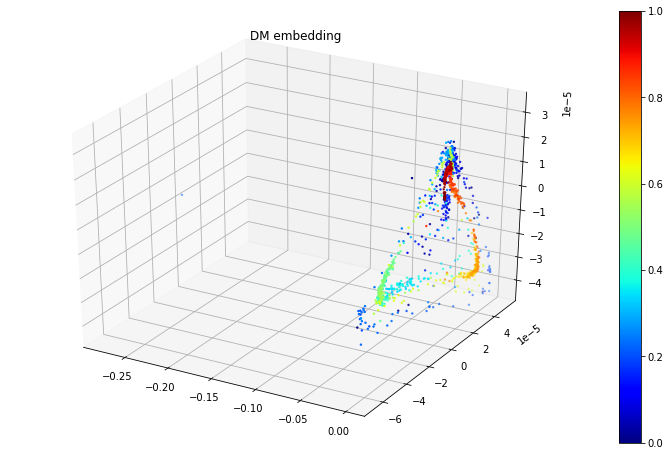

In [21]:
print('\neigenvalues: ',EIGdm2)
plotemb(EMBdm2,'DM')
savemat('EMBdm2.mat',{'EMBdm2': EMBdm2})

### roseland of X

In [22]:
%%time
sigma = 1e+5

EMBr2,EIGr2 = roseland(X,Y,sigma)

CPU times: user 13 s, sys: 45.6 ms, total: 13 s
Wall time: 13.2 s



eigenvalues:  [1.00000 0.00001 0.00000 0.00000 0.00000 0.00000]


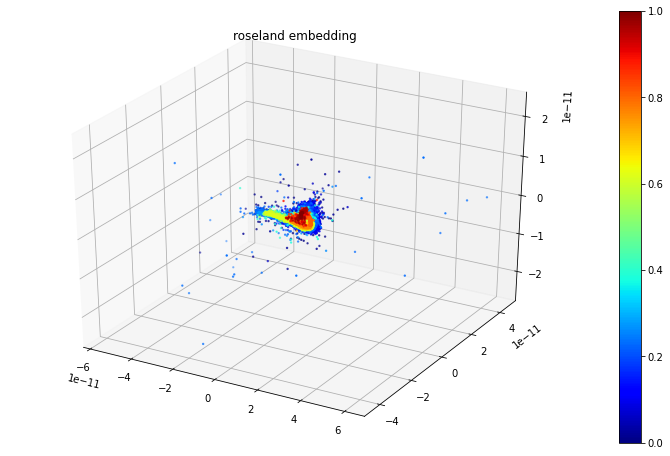

In [23]:
print('\neigenvalues: ',EIGr2)
plotemb(EMBr2,'roseland')
savemat('EMBr2.mat',{'EMBr2': EMBr2})

### DM with Nystrom extension of X

In [24]:
%%time
sigma = 1e+5

EMBn2 = nystrom(X,Y,Yind,sigma)

CPU times: user 12 s, sys: 125 ms, total: 12.1 s
Wall time: 11 s


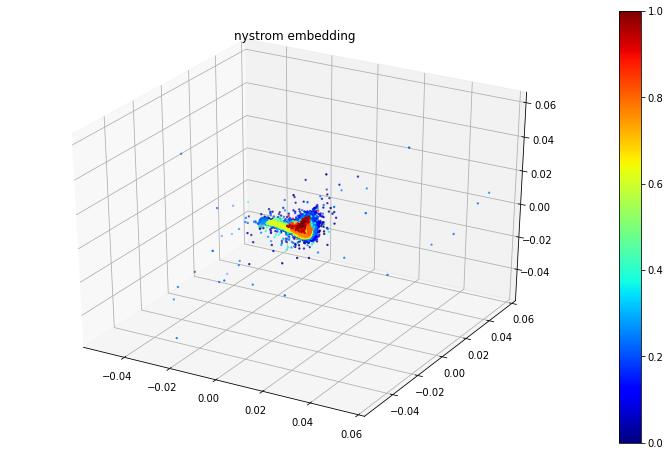

In [25]:
plotemb(EMBn2,'nystrom')
savemat('EMBn2.mat',{'EMBn2': EMBn2})

## P1 signal

X: data set, size n

Y: landmark set uniformly chosen from X, size m

XX: data set 2, size nn (for computing DM)

In [26]:
X = loadmat('/content/Pulses_GE_P1.mat')['Pulses_GE_P1']

In [27]:
n = X.shape[0]

m = round(n**0.45)
Yind = arange(n)[::int(ceil(n/m))][:m]
Y    = X[Yind]

nn = 1200
XX = X[::int(floor(n/nn))][:nn]

print('size of X, n = ',n)
print('size of Y, m = ',m)
print('size of XX, nn = ',nn)

size of X, n =  120725
size of Y, m =  194
size of XX, nn =  1200


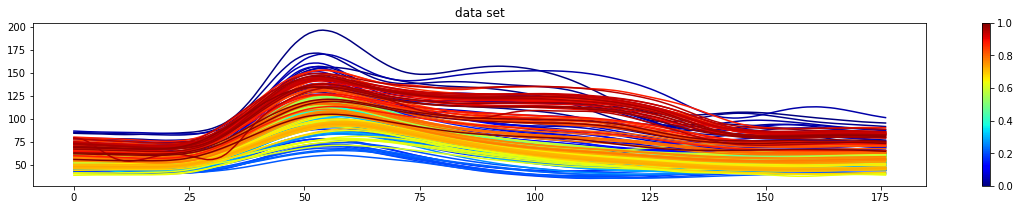

In [28]:
cmap   = cm.jet
col    = cmap(linspace(0,1,n))
colbar = plt.cm.ScalarMappable(cmap=cmap)

for i in Yind:
    plot(X[i],c=col[i])

plt.gcf().set_size_inches(20,3)
plt.colorbar(colbar)
plt.title('data set')
plt.show()

### DM of XX

In [29]:
%%time
sigma = 1e+7

EMBdm3, EIGdm3 = DM(XX,sigma)

CPU times: user 520 ms, sys: 67.2 ms, total: 587 ms
Wall time: 529 ms



eigenvalues:  [1.00000 0.01066 0.00041 0.00015 0.00006 0.00004]


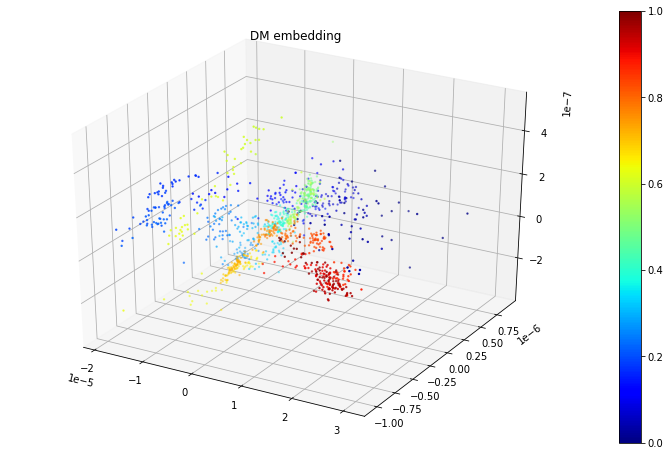

In [30]:
print('\neigenvalues: ',EIGdm3)
plotemb(EMBdm3,'DM')
savemat('EMBdm3.mat',{'EMBdm3': EMBdm3})

### roseland of X

In [31]:
%%time
sigma = 1e+7

EMBr3,EIGr3 = roseland(X,Y,sigma)

CPU times: user 5.37 s, sys: 91.7 ms, total: 5.46 s
Wall time: 5.43 s



eigenvalues:  [1.00000 0.00012 0.00000 0.00000 0.00000 0.00000]


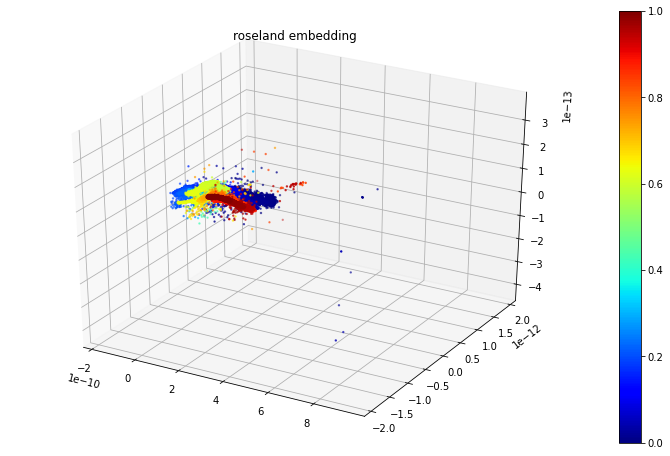

In [32]:
print('\neigenvalues: ',EIGr3)
plotemb(EMBr3,'roseland')
savemat('EMBr3.mat',{'EMBr3': EMBr3})

### DM with Nystrom extension of X

In [33]:
%%time
sigma = 1e+7

EMBn3 = nystrom(X,Y,Yind,sigma)

CPU times: user 5.47 s, sys: 133 ms, total: 5.6 s
Wall time: 4.43 s


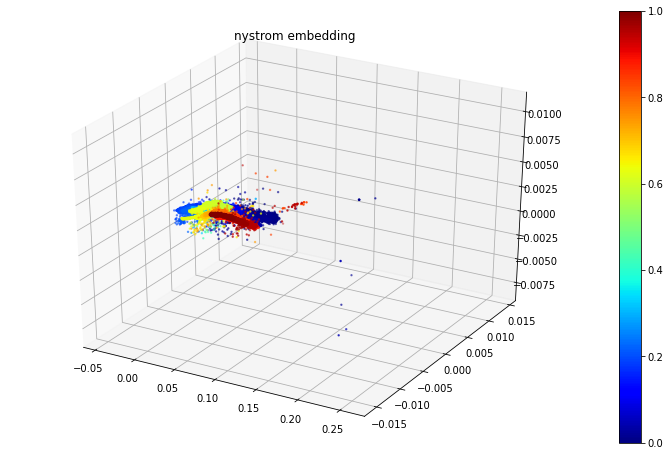

In [34]:
plotemb(EMBn3,'nystrom')
savemat('EMBn3.mat',{'EMBn3': EMBn3})